<a href="https://colab.research.google.com/github/nielsrolf/GAN-TUBerlin/blob/master/colab_gan_that_imports_from_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup
Clone or update the repo, then import it, get the data and plot it

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/gan_tu’: File exists
fatal: destination path '/content/drive/My Drive/gan_tu' already exists and is not an empty directory.
Checking out files: 100% (14/14), done.
HEAD is now at 37bfe54 more 2d stuff
Already up to date.
11493376/11490434 [==============================] - 0s 0us/step


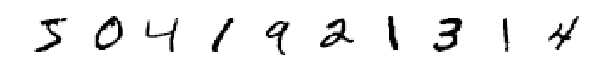

In [2]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)
PROJ = "My Drive/gan_tu" # This is a custom path.
PROJECT_PATH = join(ROOT, PROJ)

!mkdir "{PROJECT_PATH}"
!git clone https://github.com/nielsrolf/GAN-TUBerlin.git "{PROJECT_PATH}"
!cd "{PROJECT_PATH}" && git reset --hard && git pull

regular_training = False
unconnected_support_prior = False
train_d_more_often = False

from importlib.machinery import SourceFileLoader
gan = SourceFileLoader('gan', join(PROJECT_PATH, 'gan.py')).load_module()
callbacks = SourceFileLoader('callbacks', join(PROJECT_PATH, 'callbacks.py')).load_module()

from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt
import sys
import numpy as np

# Load the dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_test = X_test / 127.5 - 1.

X_train = np.reshape(X_train, [-1, 28, 28, 1])
X_test = np.reshape(X_test, [-1, 28, 28, 1])

X_train.shape
callbacks.show(X_train[:10])

# transform it to one hot encoding
Y_train = np.eye(10)[Y_train]
Y_test = np.eye(10)[Y_test]


# Regular Training

In [0]:
if regular_training:
    dcgan = gan.DCGAN(gan.Uniform(100))



    pmetric = callbacks.PMetrics(dcgan, X_test[:1000])
    period = 10
    train_callbacks = [
        (callbacks.EvolvingImageCallback(dcgan).plot, period),
        (callbacks.InterpolationCallback(dcgan).plot, period),
        (pmetric.track, 1),
        (pmetric.plot, period),
        (lambda: dcgan.save('models_mnist'), period),
        (callbacks.InverseDistributionCallback(dcgan, X_train[:100], "X_train").plot, period),
        (callbacks.InverseDistributionCallback(dcgan, X_test[:100], "X_test").plot, period)
    ]

    dcgan.train(X_train, epochs=100, batch_size=128, callbacks=train_callbacks)

# Unconnected Support Prior

In [0]:
if unconnected_support_prior:
    dcgan = gan.DCGAN(gan.Unconnected(100))


    pmetric = callbacks.PMetrics(dcgan, X_test[:1000])
    period = 10
    train_callbacks = [
        (callbacks.EvolvingImageCallback(dcgan).plot, period),
        (callbacks.InterpolationCallback(dcgan).plot, period),
        (pmetric.track, 1),
        (pmetric.plot, period),
        (lambda: dcgan.save('models_mnist_u'), period),
        (callbacks.InverseDistributionCallback(dcgan, X_train[:100], "X_train").plot, period),
        (callbacks.InverseDistributionCallback(dcgan, X_test[:100], "X_test").plot, period),
        (ModeCollapseObserver(dcgan, get_mnist_predictor()), period)
    ]

    dcgan.train(X_train, epochs=100, batch_size=128, callbacks=train_callbacks)

The assumption is wrong.

# Autoencoding GAN

We noticed that our GAN is overfitting, it cannot encode unseen images well. So the idea is to combine it with training of an autoencoder, where the generator is used as decoder.

A GAN is trained to produce realistic images from every part of the noise distribution. As Goodfellow et al have proven, the optimal state is reached when it recovers the original distribution, which implies that for each sample $x$, a latent code $z$ exists such that $G(z) = x$. However, we don't observe that this optimal state is reached.
On the other hand, autoencoders are directly trained to achieve this, and they work well and are easy to train. The combination of autoencoder and GAN training might therefore help to reach this optimal state.

In order to quantify the effect, we will compare the MSE of reconstructions of the train and test set.


0 [D loss: 0.008517, acc.: 100.00%] [G loss: 0.007010]
Train reconstruction


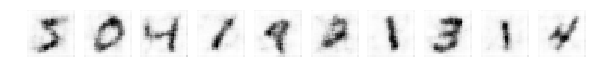

Original Train


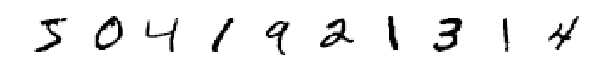

Test reconstruction


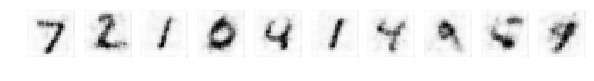

Original Test


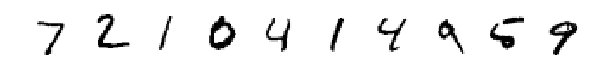

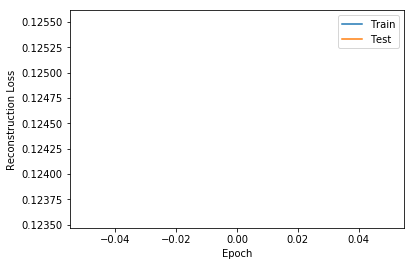


1 [D loss: 0.026807, acc.: 100.00%] [G loss: 0.095269]
Train reconstruction


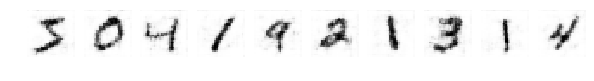

Original Train


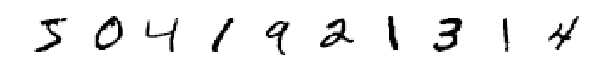

Test reconstruction


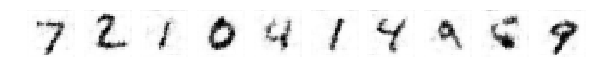

Original Test


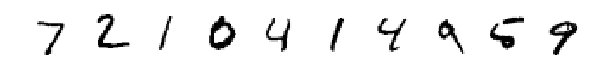

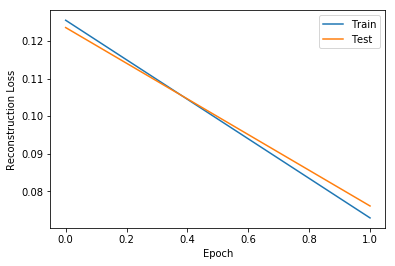


2 [D loss: 0.003346, acc.: 100.00%] [G loss: 0.014726]
Train reconstruction


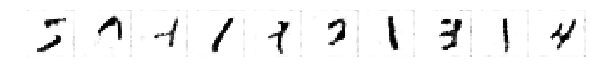

Original Train


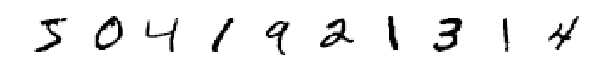

Test reconstruction


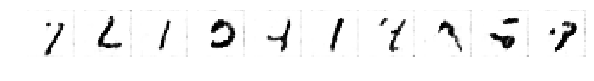

Original Test


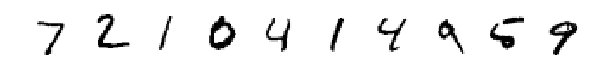

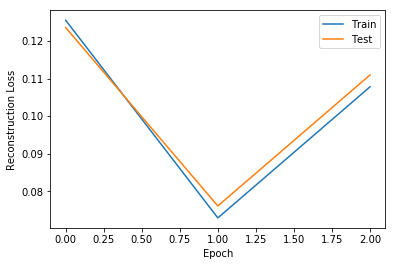


3 [D loss: 0.013241, acc.: 99.61%] [G loss: 0.192462]
Train reconstruction


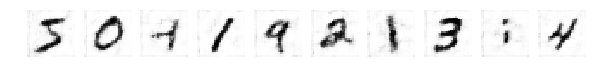

Original Train


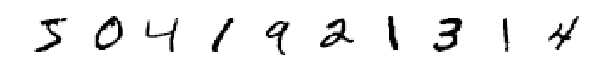

Test reconstruction


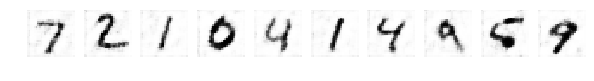

Original Test


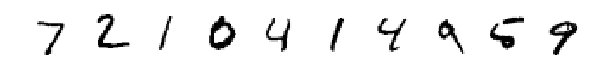

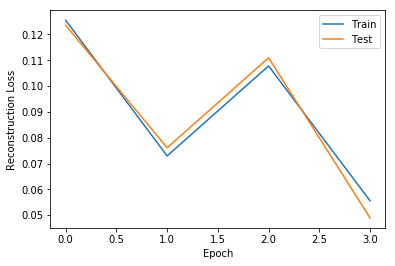


4 [D loss: 0.639468, acc.: 65.23%] [G loss: 1.667194]
Train reconstruction


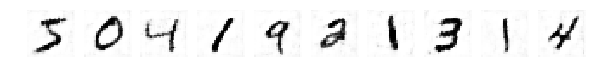

Original Train


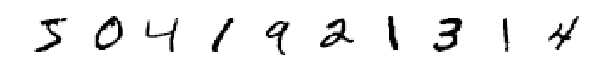

Test reconstruction


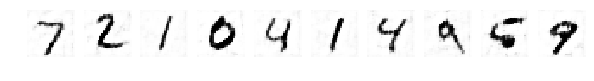

Original Test


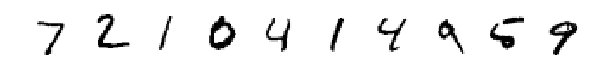

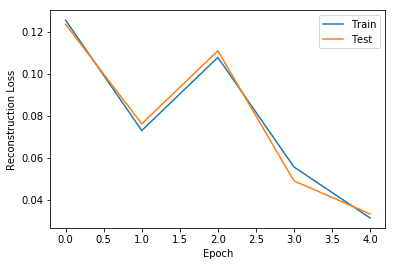


5 [D loss: 0.655141, acc.: 62.50%] [G loss: 1.397584]
Train reconstruction


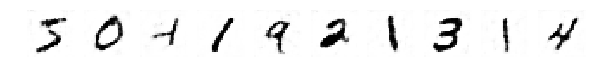

Original Train


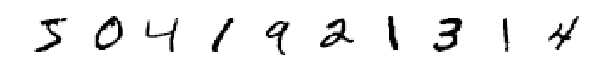

Test reconstruction


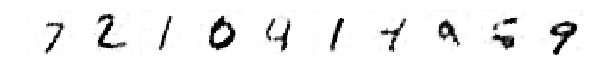

Original Test


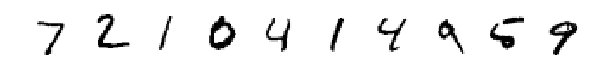

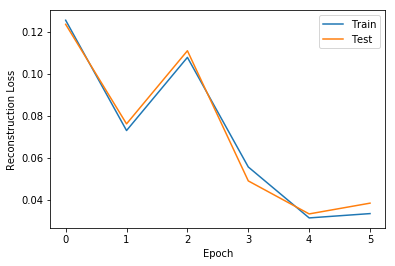


6 [D loss: 0.379263, acc.: 85.55%] [G loss: 1.091815]
Train reconstruction


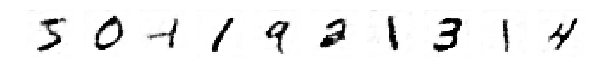

Original Train


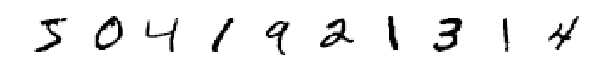

Test reconstruction


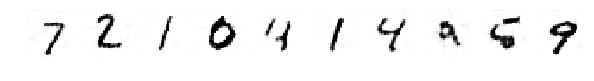

Original Test


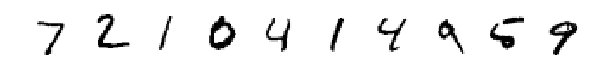

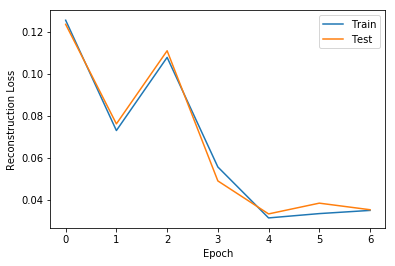


7 [D loss: 0.548736, acc.: 74.22%] [G loss: 1.453206]
Train reconstruction


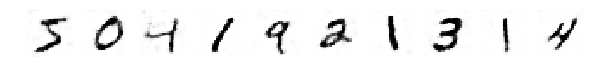

Original Train


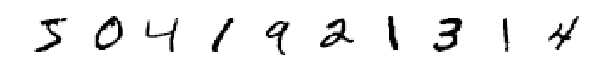

Test reconstruction


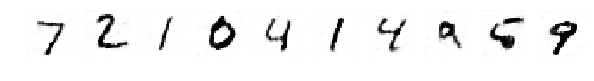

Original Test


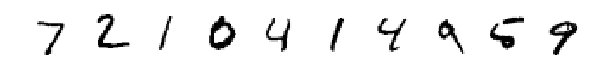

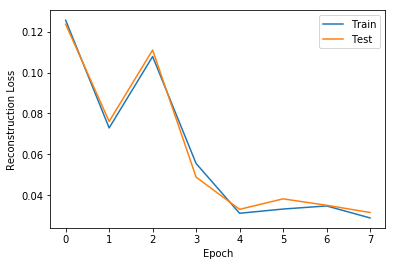


8 [D loss: 0.688894, acc.: 60.55%] [G loss: 1.514805]
Train reconstruction


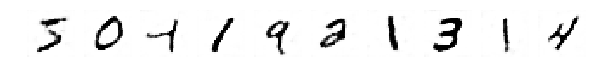

Original Train


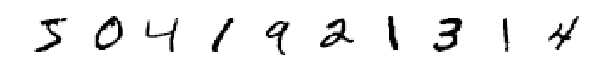

Test reconstruction


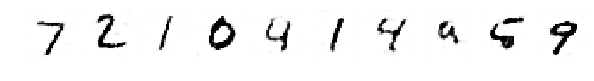

Original Test


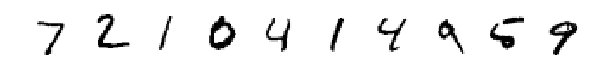

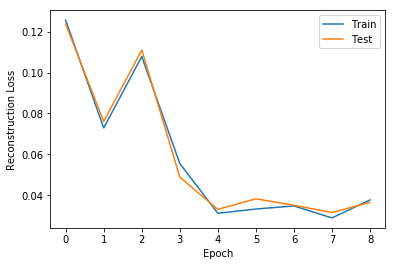


9 [D loss: 0.524857, acc.: 76.56%] [G loss: 1.168423]
Train reconstruction


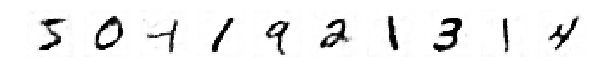

Original Train


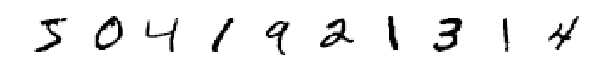

Test reconstruction


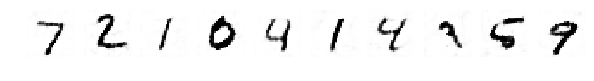

Original Test


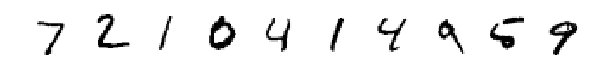

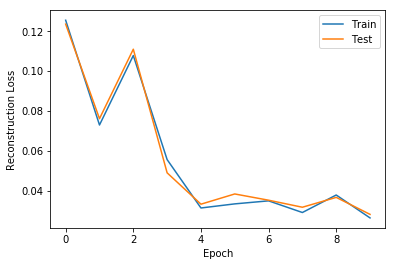

In [25]:
GradientInverser = gan.GradientInverser
show = callbacks.show

    
dcgan = gan.DCGAN(gan.Unconnected(100))

period = 10
overfitting_measure = OverfittingCallback(dcgan, X_train[:100], X_test[:100])
train_callbacks = [
    (overfitting_measure.track, 1),
    (overfitting_measure.plot, 1)
]

dcgan.train(X_train[:1280], epochs=10, batch_size=128, callbacks=train_callbacks, d_steps=5)

In [0]:
GradientInverser = gan.GradientInverser


def batches(x, batch_size):
    """
    :x: shape (N, d)
    :return: Yields batches
    """
    x = x[np.random.permutation(len(x))][:int(len(x)/batch_size)*batch_size]
    for i in range(0, len(x), batch_size):
        yield x[i:i+batch_size]
        
class DCGAN():
    def __init__(self, prior, img_shape=(28, 28, 1), load_from=None):
        self.img_shape = img_shape
        self.channels = img_shape[-1]
        self.latent_dim = prior.d
        self.prior = prior

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.G = self.generator
        self.D = self.discriminator
        self.optimizer = optimizer
        
        
        if load_from:
          self.generator.load_weights(load_from+"_g.h5")
          self.discriminator.load_weights(load_from+"_d.h5")

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.prior.d))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        noise = Input(shape=(self.prior.d,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train_step(self, imgs, d_steps, g_steps):
        batch_size = len(imgs)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Sample noise and generate a batch of new images
        for _ in range(d_steps):
            noise = self.prior(batch_size)
            gen_imgs = self.generator.predict(noise)
            # fakes_val = gen_imgs[:10]

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #assert np.allclose(self.generator.predict(noise)[:10], fakes_val), "D update effects G"

        #  Train Generator
        g_loss = -1
        for _ in range(g_steps):
            # Train the generator (wants discriminator to mistake images as real)
            y_val = self.discriminator.predict(imgs[:10])
            g_loss = self.combined.train_on_batch(noise, valid)
            #assert np.allclose(y_val, self.discriminator.predict(imgs[:10])), "G update effects D"
    
    def train(self, X_train, epochs, batch_size=128, callbacks=[], d_steps=1, g_steps=1):

        X_train = np.reshape(X_train, [-1]+list(self.img_shape))

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            for batch_id, imgs in enumerate(batches(X_train, batch_size)):
                self.train_step(imgs, d_steps, g_steps)
                
            for callback, period in callbacks:
                if (epoch+1) % period == 0:
                    callback()
    
    def save(self, file_prefix='dcgan'):
        self.generator.save_weights(f"{file_prefix}_g.h5")
        self.discriminator.save_weights(f"{file_prefix}_d.h5")
        
class OverfittingCallback():
    def __init__(self, gan, x_train, x_test, plot_reconstructions=True, Inverser=GradientInverser):
        # assumes that track is called after every epoch
        self.gan = gan
        self.x_train = x_train
        self.x_test = x_test
        self.invert = GradientInverser(gan)
        self.train_reconstruction_mse = []
        self.test_reconstruction_mse = []
        self.plot_reconstructions = plot_reconstructions

    def track(self):
        train_inv = self.invert(self.x_train)
        train_reconstruction = self.gan.generator.predict(train_inv)
        self.train_reconstruction_mse += [np.mean(np.square(train_reconstruction - self.x_train))]
        test_inv = self.invert(self.x_test)
        test_reconstruction = self.gan.generator.predict(test_inv)
        self.test_reconstruction_mse += [np.mean(np.square(test_reconstruction - self.x_test))]
        if self.plot_reconstructions:
            print('Train reconstruction')
            show(train_reconstruction[:10])
            print('Original Train')
            show(self.x_train[:10])

            print('Test reconstruction')
            show(test_reconstruction[:10])
            print('Original Test')
            show(self.x_test[:10])
    
    def plot(self):
        epochs = list(range(len(self.train_reconstruction_mse)))
        plt.plot(epochs, self.train_reconstruction_mse, label='Train')
        plt.plot(epochs, self.test_reconstruction_mse, label='Test')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss')
        plt.legend()
        plt.show()
        
        
dcgan = gan.DCGAN(gan.Unconnected(100))

period = 10
overfitting_measure = OverfittingCallback(dcgan, X_train[:100], X_test[:100])
train_callbacks = [
    (overfitting_measure.track, 1),
    (overfitting_measure.plot, 1)
]

dcgan.train(X_train[:1280], epochs=10, batch_size=128, callbacks=train_callbacks, d_steps=5)

In [0]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

show = callbacks.show

class AutoencodingGAN(DCGAN):
    def __init__(self, prior, img_shape=(28, 28, 1), load_from=None, train_decoder=False):
        super().__init__(prior, img_shape, load_from)

        self.encoder = self.build_encoder()
        x = Input(shape=(self.img_shape))
        encoded = self.encoder(x)
        if not train_decoder:
            self.generator.trainable = False
        decoded = self.generator(encoded)
        self.autoencoder = Model(x, decoded)
        self.autoencoder.compile(loss='mean_squared_error', optimizer=self.optimizer)


        if load_from:
            self.generator.load_weights(load_from+"_g.h5")
            self.discriminator.load_weights(load_from+"_d.h5")
            try:
                self.encoder.load_weights(load_from+"_enc.h5")
            except Exception as e:
                print('WARNING: loaded the gan but the autoencoder is not loaded')
                
    def build_encoder(self):
        # let's use the discriminator architecture
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(self.prior.d, activation='tanh')) 
        # we assume that the prior is scaled from -1 to 1, otherwise 
        # we would need to scale explicitly here

        img = Input(shape=self.img_shape)
        encoded = model(img)

        return Model(img, encoded)            
            
        
    def train_step(self, imgs, d_steps, g_steps, ae_steps=0.5):
        batch_size = len(imgs)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Train the autoencoder
        ae_steps_done = 0
        while (ae_steps - ae_steps_done) > np.random.uniform(0, 1):
            self.autoencoder.train_on_batch(imgs, imgs)
            ae_steps_done += 1
        
        # Sample noise and generate a batch of new images
        for _ in range(d_steps):
            noise = self.prior(batch_size)
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        
        
        #  Train Generator
        g_loss = -1
        for _ in range(g_steps):
            y_val = self.discriminator.predict(imgs[:10])
            g_loss = self.combined.train_on_batch(noise, valid)
            
    def encode(self, x):
        return self.encoder.predict(x)
    
    def generate(self, z):
        return self.generator.predict(z)
    
    def discriminate(self, x):
        return self.discriminator.predict(x)
            
            
class InverseDistributionCallback():
    def __init__(self, gan, x, title="", show_samples=show, inverse=None):
        if inverse is None:
            inverse = GradientInverser(gan).invert
        self.gan = gan
        self.x = x
        self.inverse = inverse
        self.title=title
        self.show_samples = show_samples
        
    def plot(self):
        z = self.gan.prior(1000)
        x_inv = self.inverse(self.x)
        plt.plot(z[:,0], z[:,1], "o", label='Prior')
        plt.plot(x_inv[:,0], x_inv[:,1], "o", label='Reconstruction')
        plt.title(self.title)
        plt.show()

        if self.show_samples:
            print('Reconstruction', self.title)
            self.show_samples(self.gan.G.predict(x_inv[:10]))
            print('Original', self.title)
            self.show_samples(self.x[:10])
            
            


## Train additional encoder without changing GAN training

In [0]:
aegan = AutoencodingGAN(gan.Unconnected(100))

period = 10
overfitting_measure = OverfittingCallback(aegan, X_train[:100], X_test[:100], Inverser=aegan.encode)
inverse_distribution = InverseDistributionCallback(aegan, X_test[:1000], inverse=aegan.encode, show_samples=False)

train_callbacks = [
    (callbacks.EvolvingImageCallback(aegan).plot, 1),
    (overfitting_measure.track, 1),
    (overfitting_measure.plot, 1),
    (inverse_distribution.plot, 1)
]

aegan.train(X_train, epochs=10, batch_size=128, callbacks=train_callbacks, d_steps=5)

## Include generator in Aeutoencder training

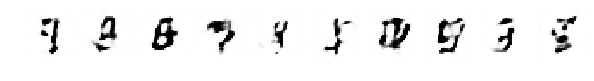

Train reconstruction


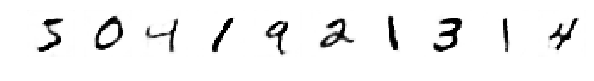

Original Train


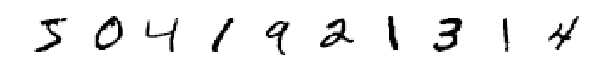

Test reconstruction


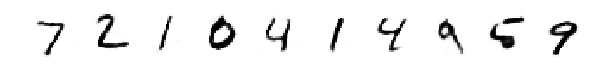

Original Test


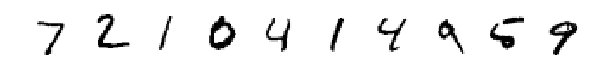

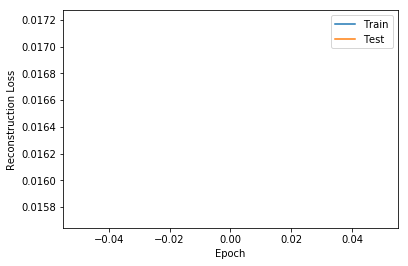

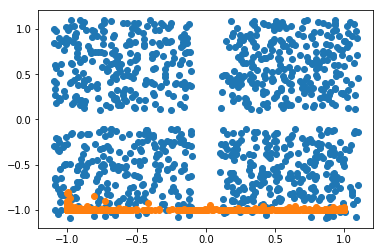

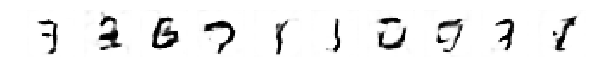

Train reconstruction


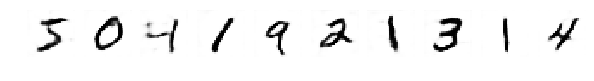

Original Train


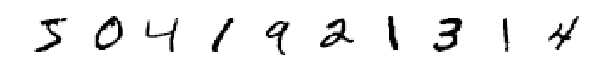

Test reconstruction


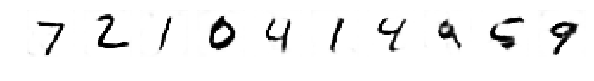

Original Test


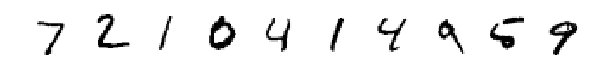

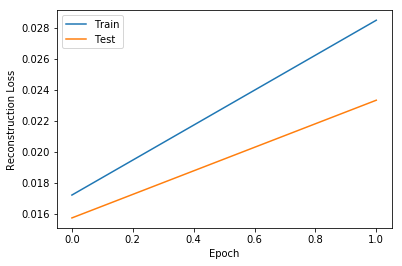

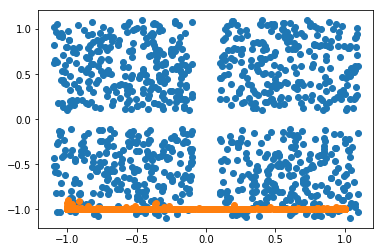

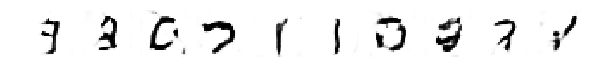

Train reconstruction


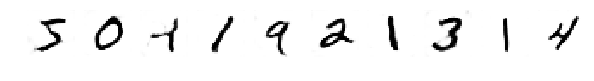

Original Train


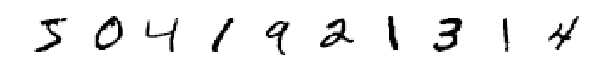

Test reconstruction


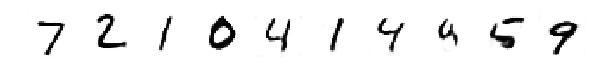

Original Test


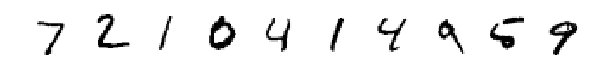

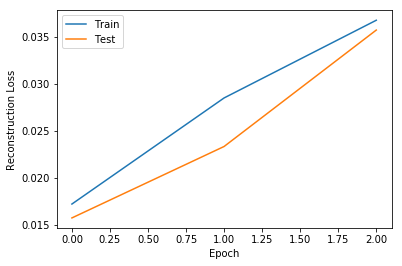

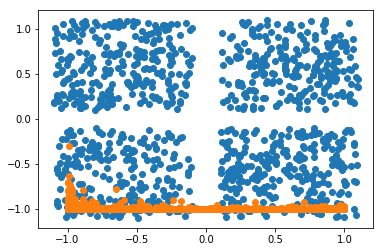

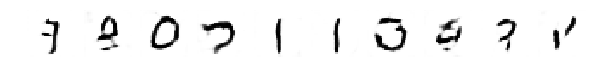

Train reconstruction


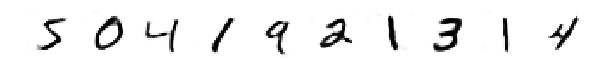

Original Train


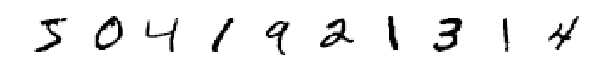

Test reconstruction


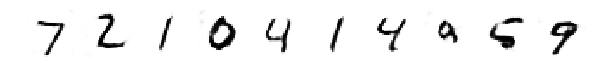

Original Test


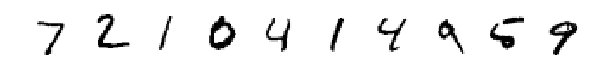

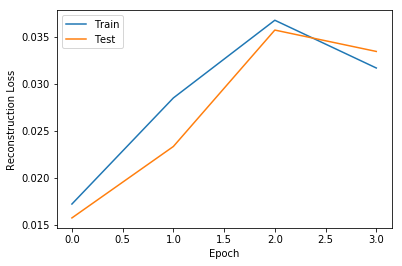

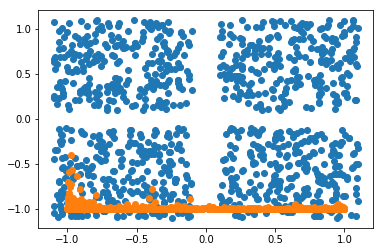

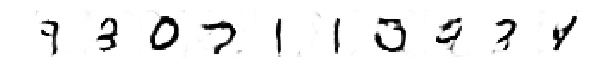

Train reconstruction


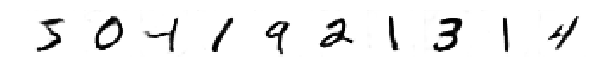

Original Train


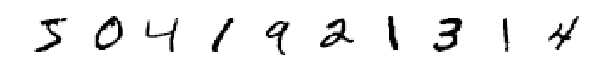

Test reconstruction


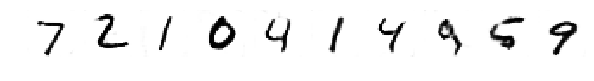

Original Test


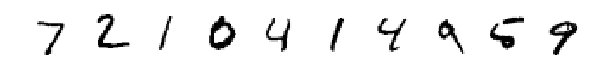

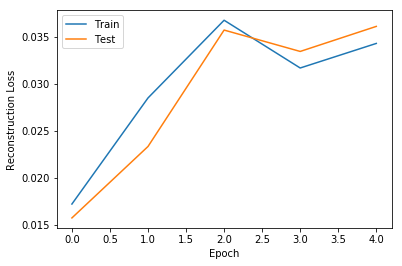

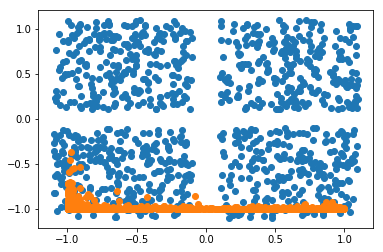

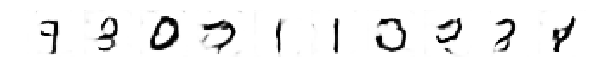

Train reconstruction


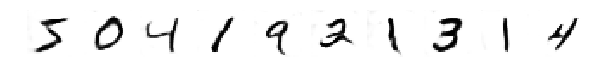

Original Train


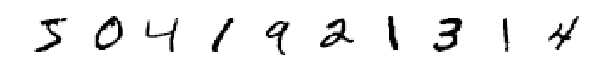

Test reconstruction


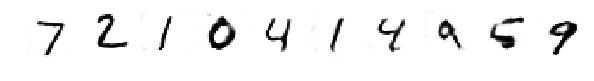

Original Test


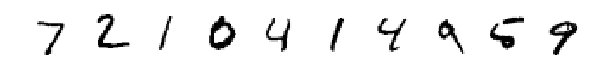

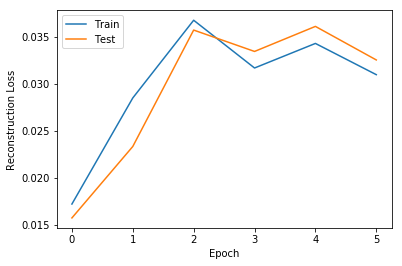

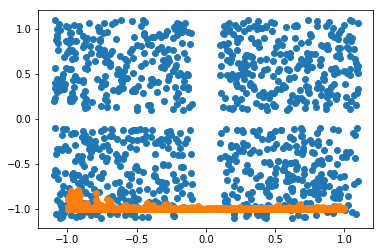

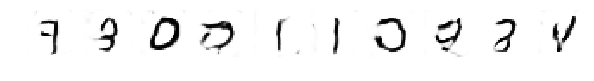

Train reconstruction


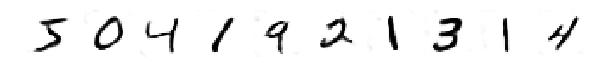

Original Train


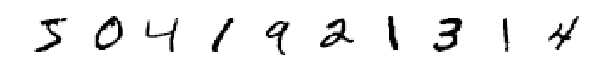

Test reconstruction


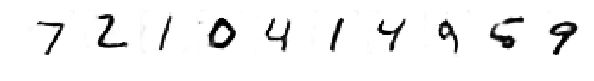

Original Test


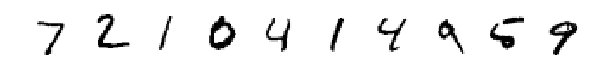

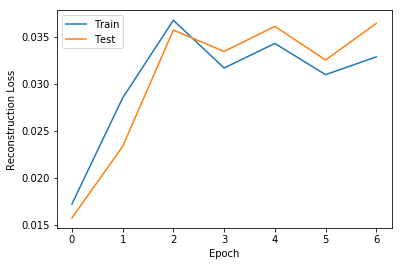

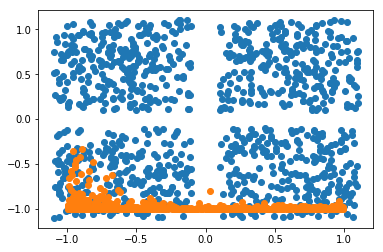

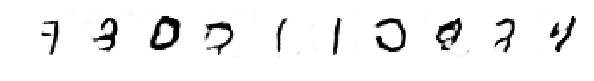

Train reconstruction


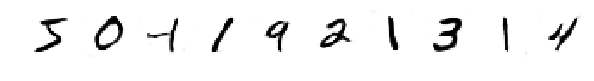

Original Train


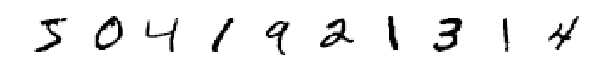

Test reconstruction


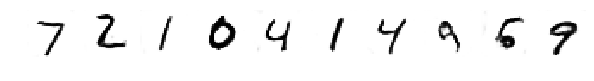

Original Test


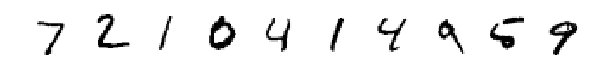

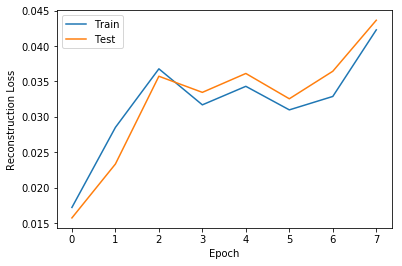

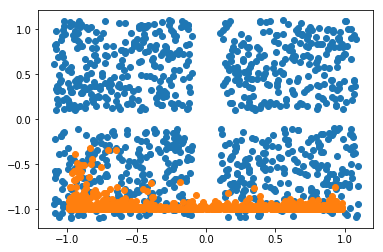

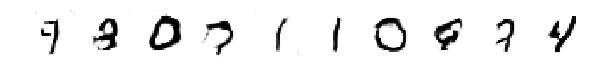

Train reconstruction


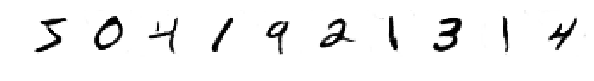

Original Train


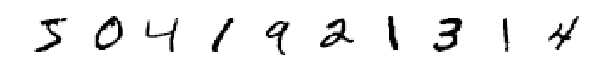

Test reconstruction


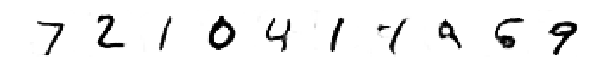

Original Test


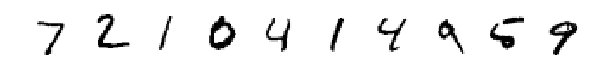

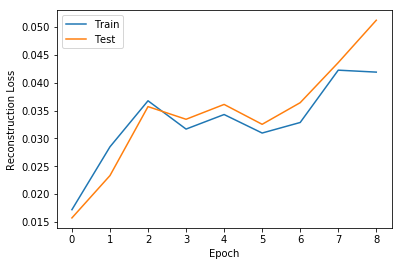

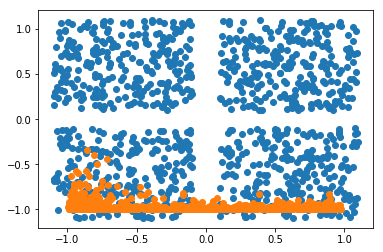

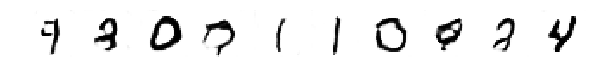

Train reconstruction


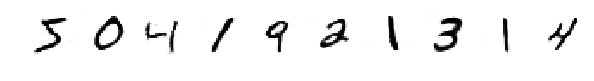

Original Train


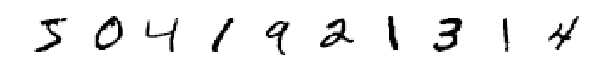

Test reconstruction


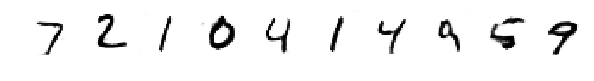

Original Test


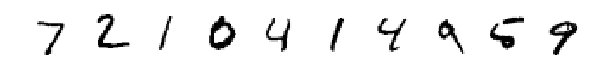

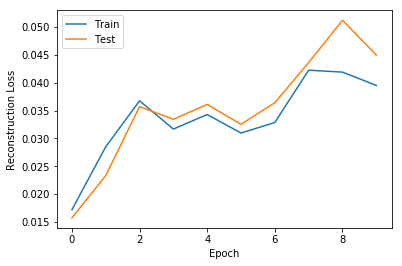

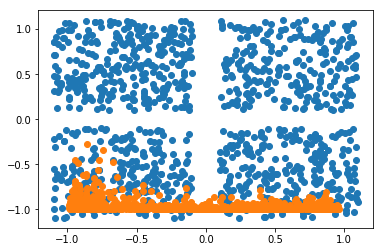

In [32]:
aegan = AutoencodingGAN(gan.Unconnected(100), train_decoder=True)

period = 10
overfitting_measure = OverfittingCallback(aegan, X_train[:100], X_test[:100], Inverser=aegan.encode)
inverse_distribution = InverseDistributionCallback(aegan, X_test[:1000], inverse=aegan.encode, show_samples=False)

train_callbacks = [
    (callbacks.EvolvingImageCallback(aegan).plot, 1),
    (overfitting_measure.track, 1),
    (overfitting_measure.plot, 1),
    (inverse_distribution.plot, 1)
]

aegan.train(X_train, epochs=10, batch_size=128, callbacks=train_callbacks, d_steps=5)

Distance between found encodings 28.123562465529055
Gradient Based Reconstruction


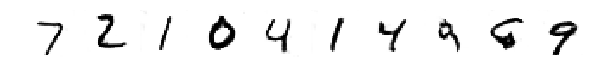

Autoencoder Based Reconstruction


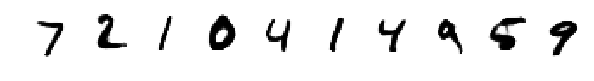

AE  MSE: 0.09448027124224219 
GAN MSE: 0.044114283911177


In [33]:
# Compare GradientInverser and Encoder

gradient_inverter = GradientInverser(aegan)
samples = X_test[:10]
z_g = gradient_inverter.invert(samples)
z_ae = aegan.encode(samples)
print('Distance between found encodings', np.linalg.norm(z_g - z_ae))
print('Gradient Based Reconstruction')
x_g = aegan.generate(z_g)
show(x_g)
print('Autoencoder Based Reconstruction')
x_ae = aegan.generate(z_ae)
show(x_ae)
print(f"AE  MSE: {np.mean(np.square(x_ae-samples))} \nGAN MSE: {np.mean(np.square(x_g-samples))}")




Interpolation between reconstructions
------------------


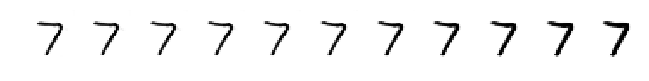

Distance in z/norm(z_g): 1.45
Distance in x/norm(x): 0.29
Distance after applying transformation to next sample 0.6419915248805506


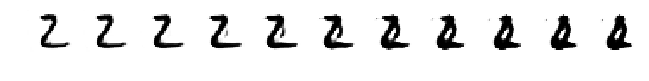

------------------


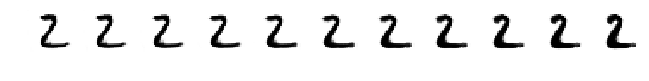

Distance in z/norm(z_g): 1.33
Distance in x/norm(x): 0.38
Distance after applying transformation to next sample 0.31486353262580646


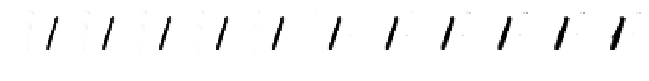

------------------


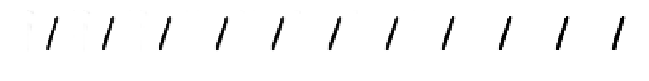

Distance in z/norm(z_g): 1.70
Distance in x/norm(x): 0.14
Distance after applying transformation to next sample 0.6228111429142776


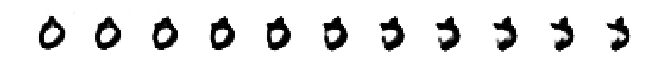

------------------


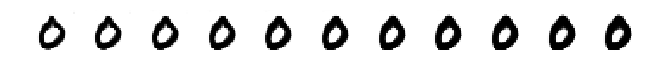

Distance in z/norm(z_g): 1.25
Distance in x/norm(x): 0.41
Distance after applying transformation to next sample 0.6662020256855208


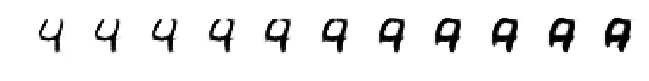

------------------


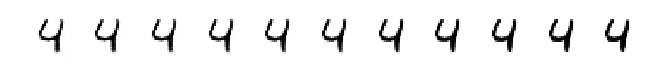

Distance in z/norm(z_g): 1.30
Distance in x/norm(x): 0.23
Distance after applying transformation to next sample 0.35030143939212766


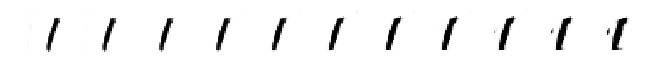

In [49]:
print("Interpolation between reconstructions")

def interpolate(generate, z0, z1):
    b = z0[None,...]
    a = z1[None,...] - b
    x = np.arange(0, 1.05, 0.1)[...,None]
    z = a*x + b
    show(generate(z))

for i in range(5):
    print("------------------")
    interpolate(aegan.generate, z_g[i], z_ae[i])
    print(f"Distance in z/norm(z_g): {np.linalg.norm(z_g[i] - z_ae[i])/np.linalg.norm(z_g[i]):.2f}\n"
         f"Distance in x/norm(x): {np.linalg.norm(x_g[i]-x_ae[i])/np.linalg.norm(samples[i]):.2f}\n"
         "Distance after applying transformation to next sample",
         np.linalg.norm(aegan.generate(z_g[i+1][None,...]) - 
                        aegan.generate((z_g[i+1] -  z_g[i] + z_ae[i])[None,...]))/np.linalg.norm(samples[i+1]))
    interpolate(aegan.generate, z_g[i+1],  z_g[i+1] -  z_g[i] + z_ae[i])
    

## Train vanilla Autoencoder

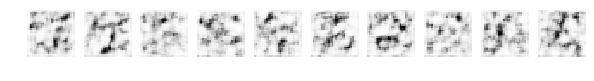

Train reconstruction


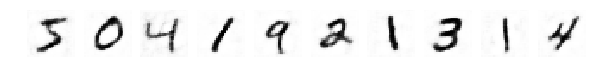

Original Train


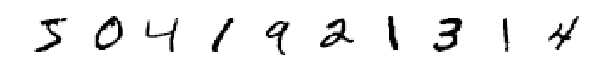

Test reconstruction


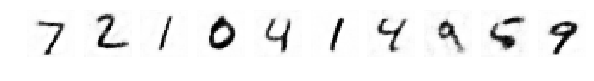

Original Test


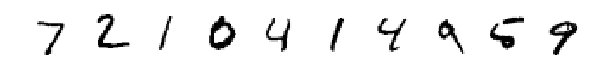

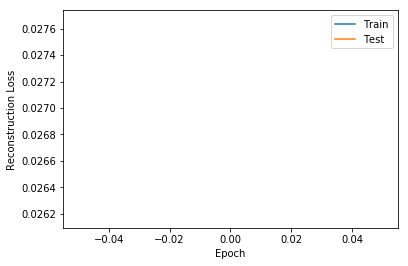

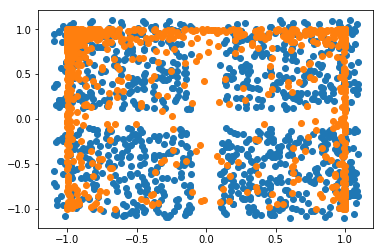

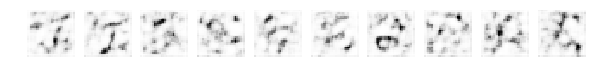

Train reconstruction


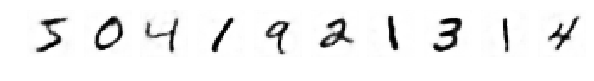

Original Train


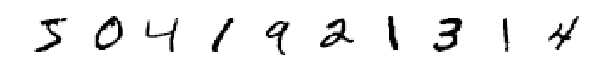

Test reconstruction


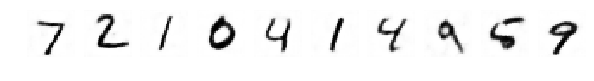

Original Test


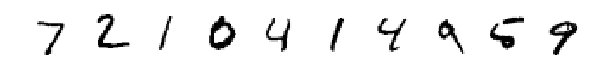

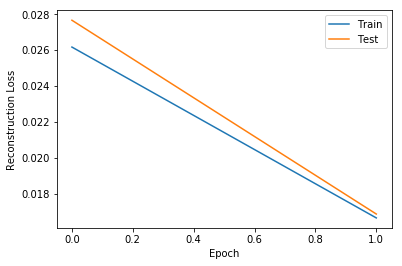

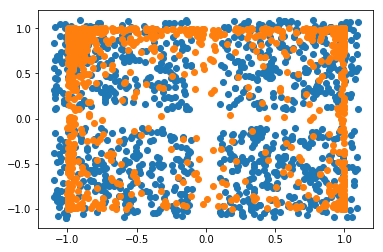

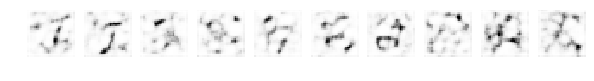

Train reconstruction


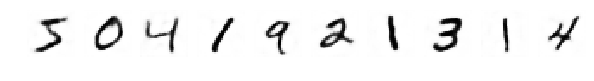

Original Train


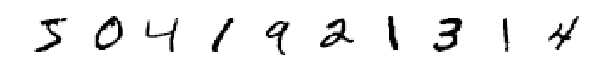

Test reconstruction


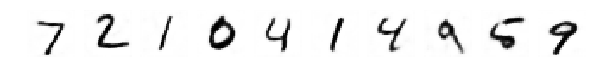

Original Test


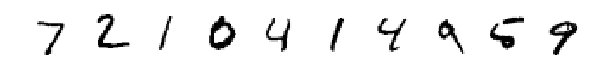

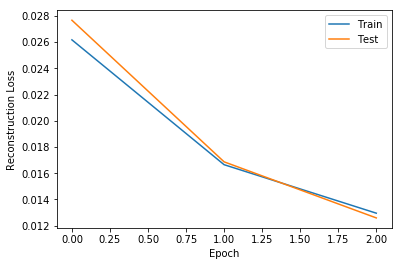

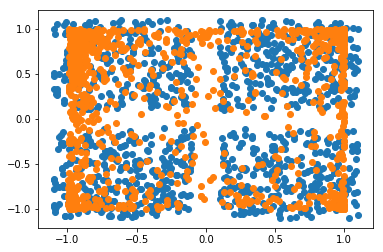

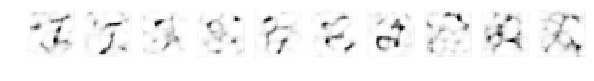

Train reconstruction


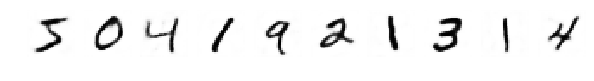

Original Train


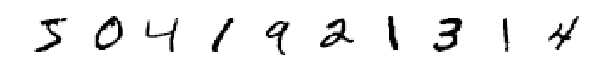

Test reconstruction


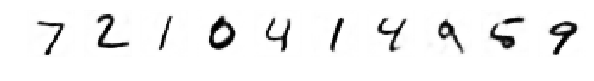

Original Test


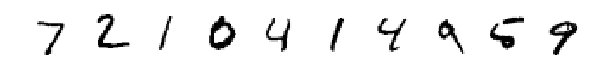

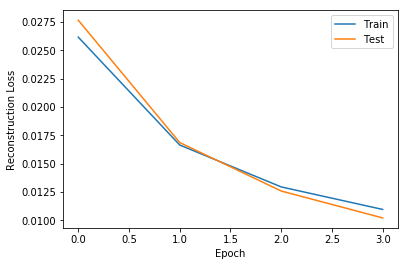

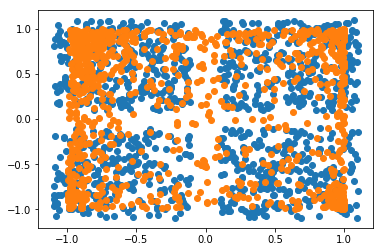

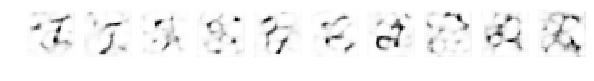

Train reconstruction


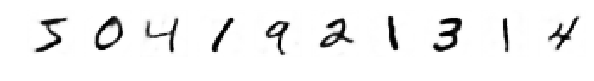

Original Train


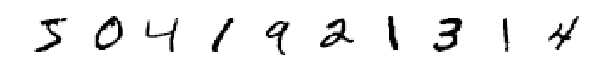

Test reconstruction


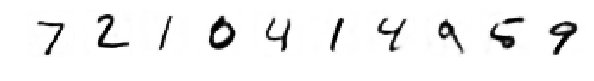

Original Test


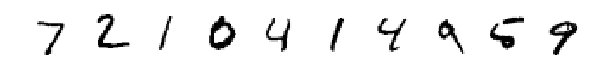

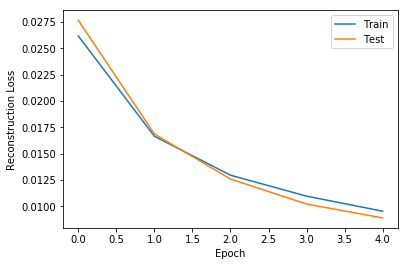

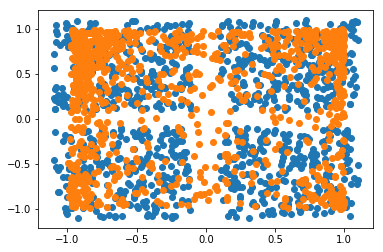

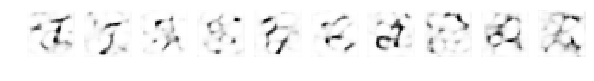

Train reconstruction


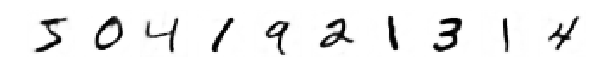

Original Train


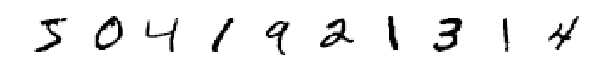

Test reconstruction


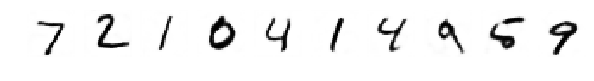

Original Test


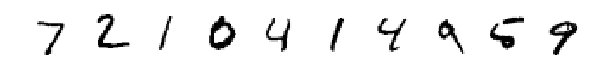

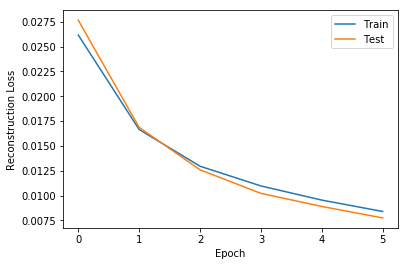

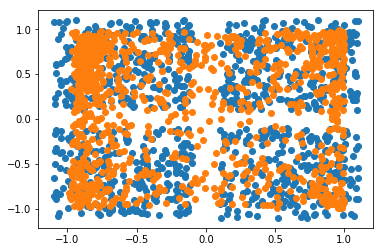

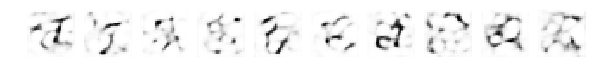

Train reconstruction


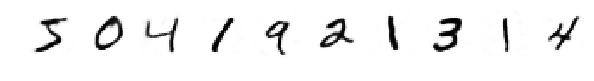

Original Train


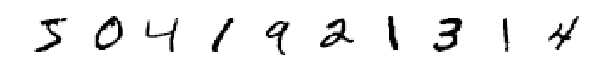

Test reconstruction


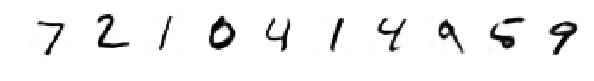

Original Test


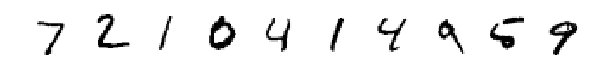

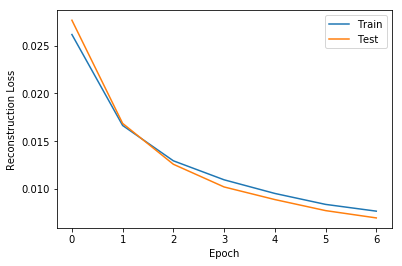

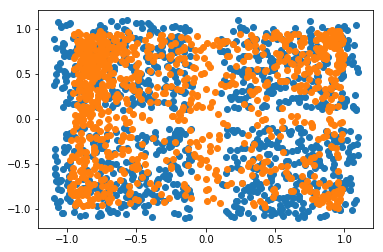

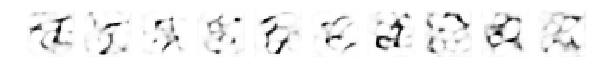

Train reconstruction


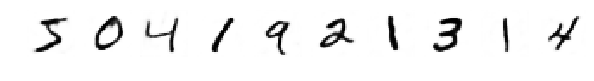

Original Train


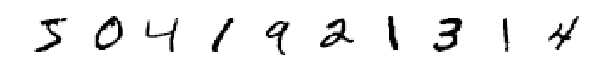

Test reconstruction


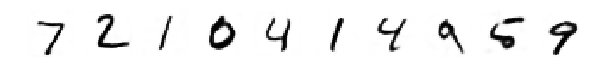

Original Test


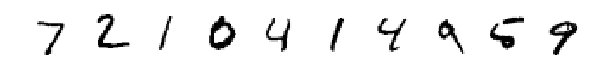

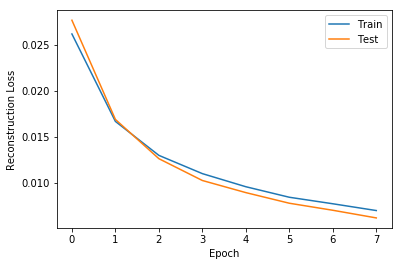

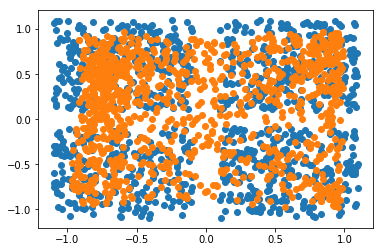

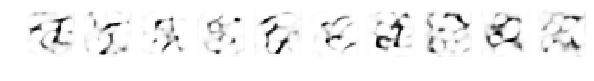

Train reconstruction


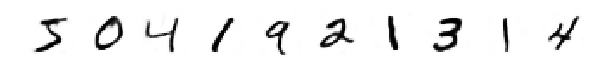

Original Train


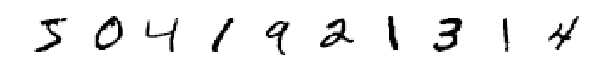

Test reconstruction


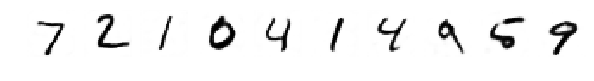

Original Test


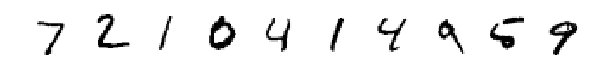

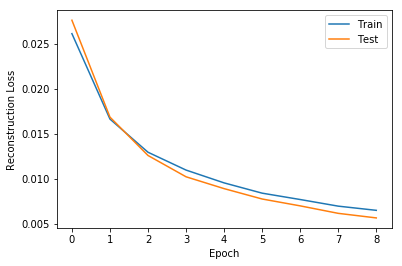

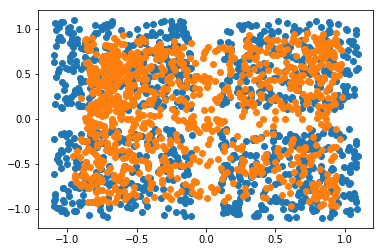

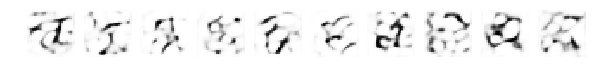

Train reconstruction


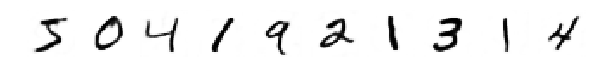

Original Train


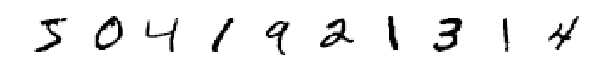

Test reconstruction


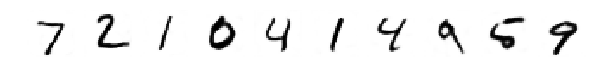

Original Test


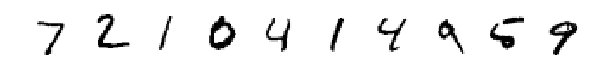

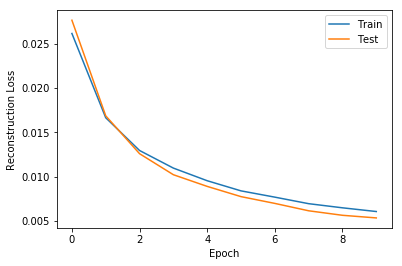

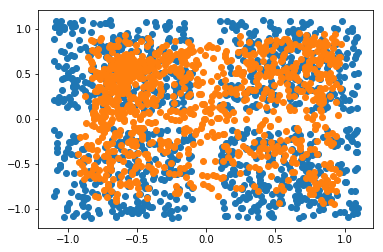

In [22]:
aegan = AutoencodingGAN(gan.Unconnected(100))

period = 10
overfitting_measure = OverfittingCallback(aegan, X_train[:100], X_test[:100], Inverser=aegan.encode)
inverse_distribution = InverseDistributionCallback(aegan, X_test[:1000], inverse=aegan.encode, show_samples=False)

train_callbacks = [
    (callbacks.EvolvingImageCallback(aegan).plot, 1),
    (overfitting_measure.track, 1),
    (overfitting_measure.plot, 1),
    (inverse_distribution.plot, 1)
]

aegan.train(X_train, epochs=10, batch_size=128, callbacks=train_callbacks, d_steps=0, g_steps=0)